In [1]:
import os
import sys
import base64
import matplotlib.pyplot as plt
import numpy as np
from urllib import parse
import pandas as pd

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 
if root_directory not in sys.path:
    sys.path.append(root_directory)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es

In [2]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}

data=get_from_es(body,'scanR2')

In [5]:
26062*100/193099

13.49670376335455

In [4]:
114543*100/193099

59.318277153170136

In [6]:
46963*100/193099

24.320685244356522

In [3]:
data

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2714832, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 2521733},
    {'key': 'not_ipbes', 'doc_count': 2509153},
    {'key': 'ipbes', 'doc_count': 205679},
    {'key': 'ipcc', 'doc_count': 193099},
    {'key': 'ipcc_adaptation', 'doc_count': 114543},
    {'key': 'ipcc_mitigation', 'doc_count': 46963},
    {'key': 'ipcc_science', 'doc_count': 26062}]}}}

In [ ]:
data 

{'took': 3957,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2791265, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 2747281},
    {'key': 'ipcc', 'doc_count': 43984},
    {'key': 'ipcc_adaptation', 'doc_count': 22288},
    {'key': 'ipcc_science', 'doc_count': 9909},
    {'key': 'ipcc_mitigation', 'doc_count': 8775}]}}}

In [8]:
193099*100/2714832

7.1127421512638715

C:\Users\haallat\AppData\Local\Temp\ipykernel_18408\3550470597.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=20)


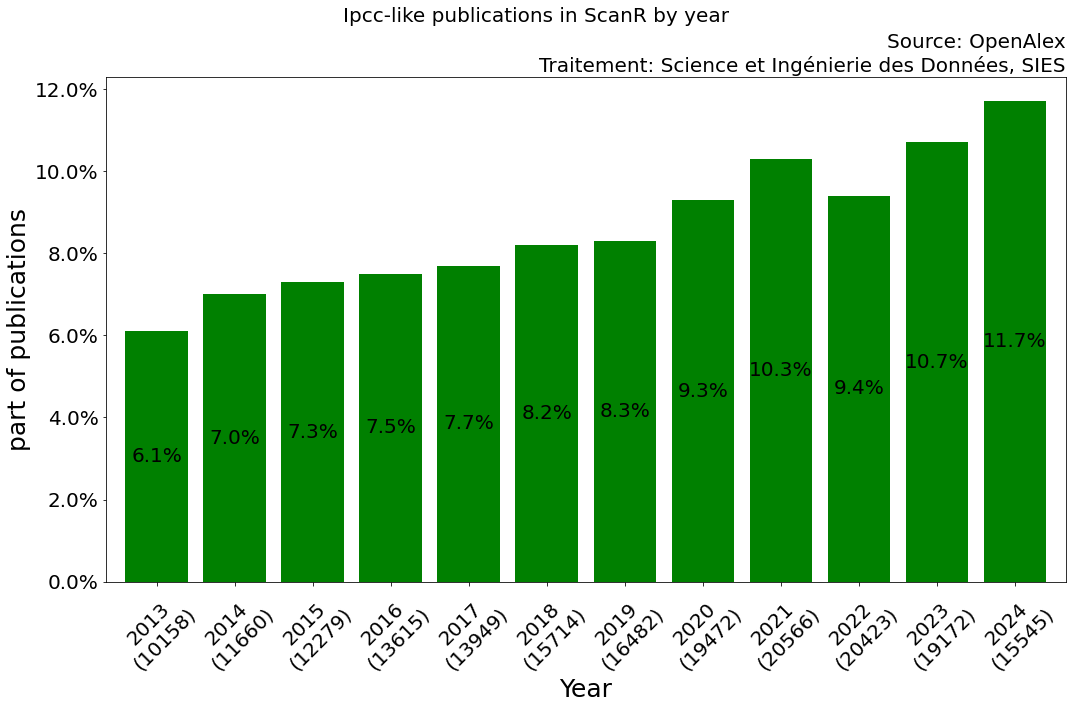

In [14]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013 and x['key']<=2024:
      #data_counts[x['key']]=[]
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc','nb'])
df = df.sort_index()

ax = df['ipcc'].plot(kind='bar', figsize=(15, 10), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=20)

ax.set_xlabel('Year', fontsize=25)
x_labels = [f"{index}\n({int(row['nb'])})" for index, row in df.iterrows()]
ax.set_xticklabels(x_labels, rotation=45, fontsize=20)
ax.set_ylabel(f'part of publications', fontsize=25)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=20)

plt.suptitle("Ipcc-like publications in ScanR by year", size=20)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_18408\2621286459.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(t)}%" for t in ax.get_yticks()], fontsize=20)


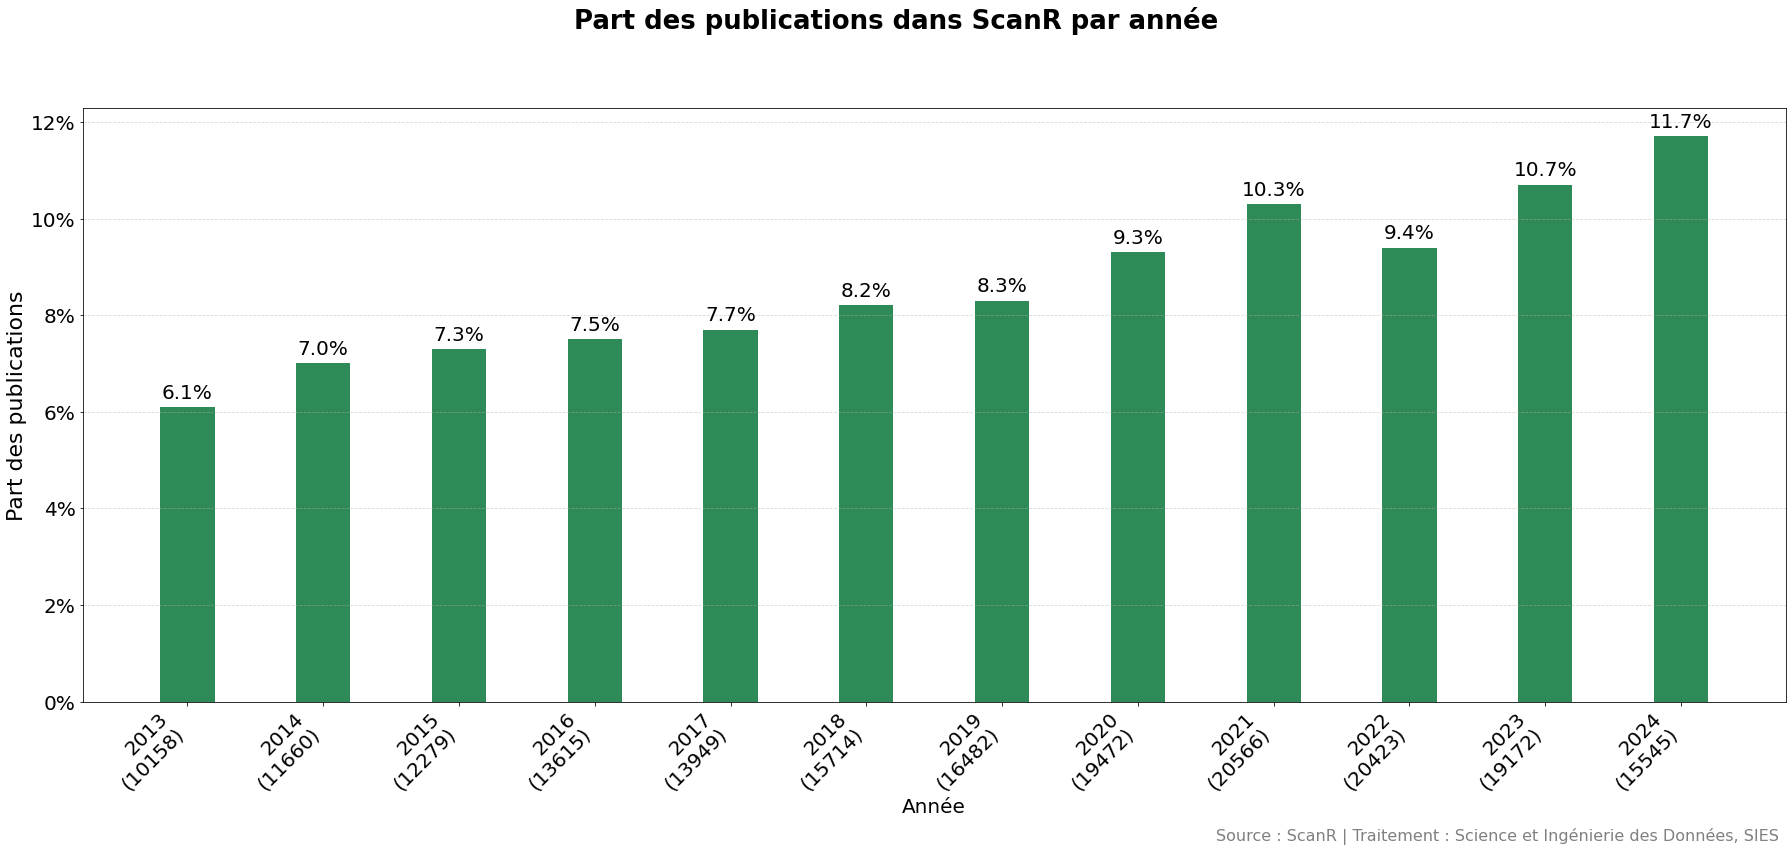

In [ ]:
import matplotlib.pyplot as plt

df = df.sort_index()
fig, ax = plt.subplots(figsize=(25, 12))  
bars = ax.bar(
    df.index.astype(str),
    df['ipcc'],
    width=0.4, 
    color='#2E8B57'
)

for i, (index, row) in enumerate(df.iterrows()):
    if row['ipcc'] > 0:
        ax.text(
            i,
            row['ipcc'] + 0.1,
            f"{row['ipcc']:.1f}%",
            ha='center',
            va='bottom',
            fontsize=20, 
            color='black'
        )

x_labels = [f"{index}\n({int(row['nb'])})" for index, row in df.iterrows()]
ax.set_xticks(range(len(df)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=20)
ax.set_ylabel('Part des publications', fontsize=22)
ax.set_yticklabels([f"{int(t)}%" for t in ax.get_yticks()], fontsize=20)
ax.set_xlabel('Année', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.suptitle("Part des publications dans ScanR par année", fontsize=26, weight='bold')
fig.text(
    0.99, 0.01,
    "Source : ScanR | Traitement : Science et Ingénierie des Données, SIES",
    ha='right', va='bottom', fontsize=16, color='gray'
)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])  
plt.show()


C:\Users\haallat\AppData\Local\Temp\ipykernel_7244\3031363117.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)


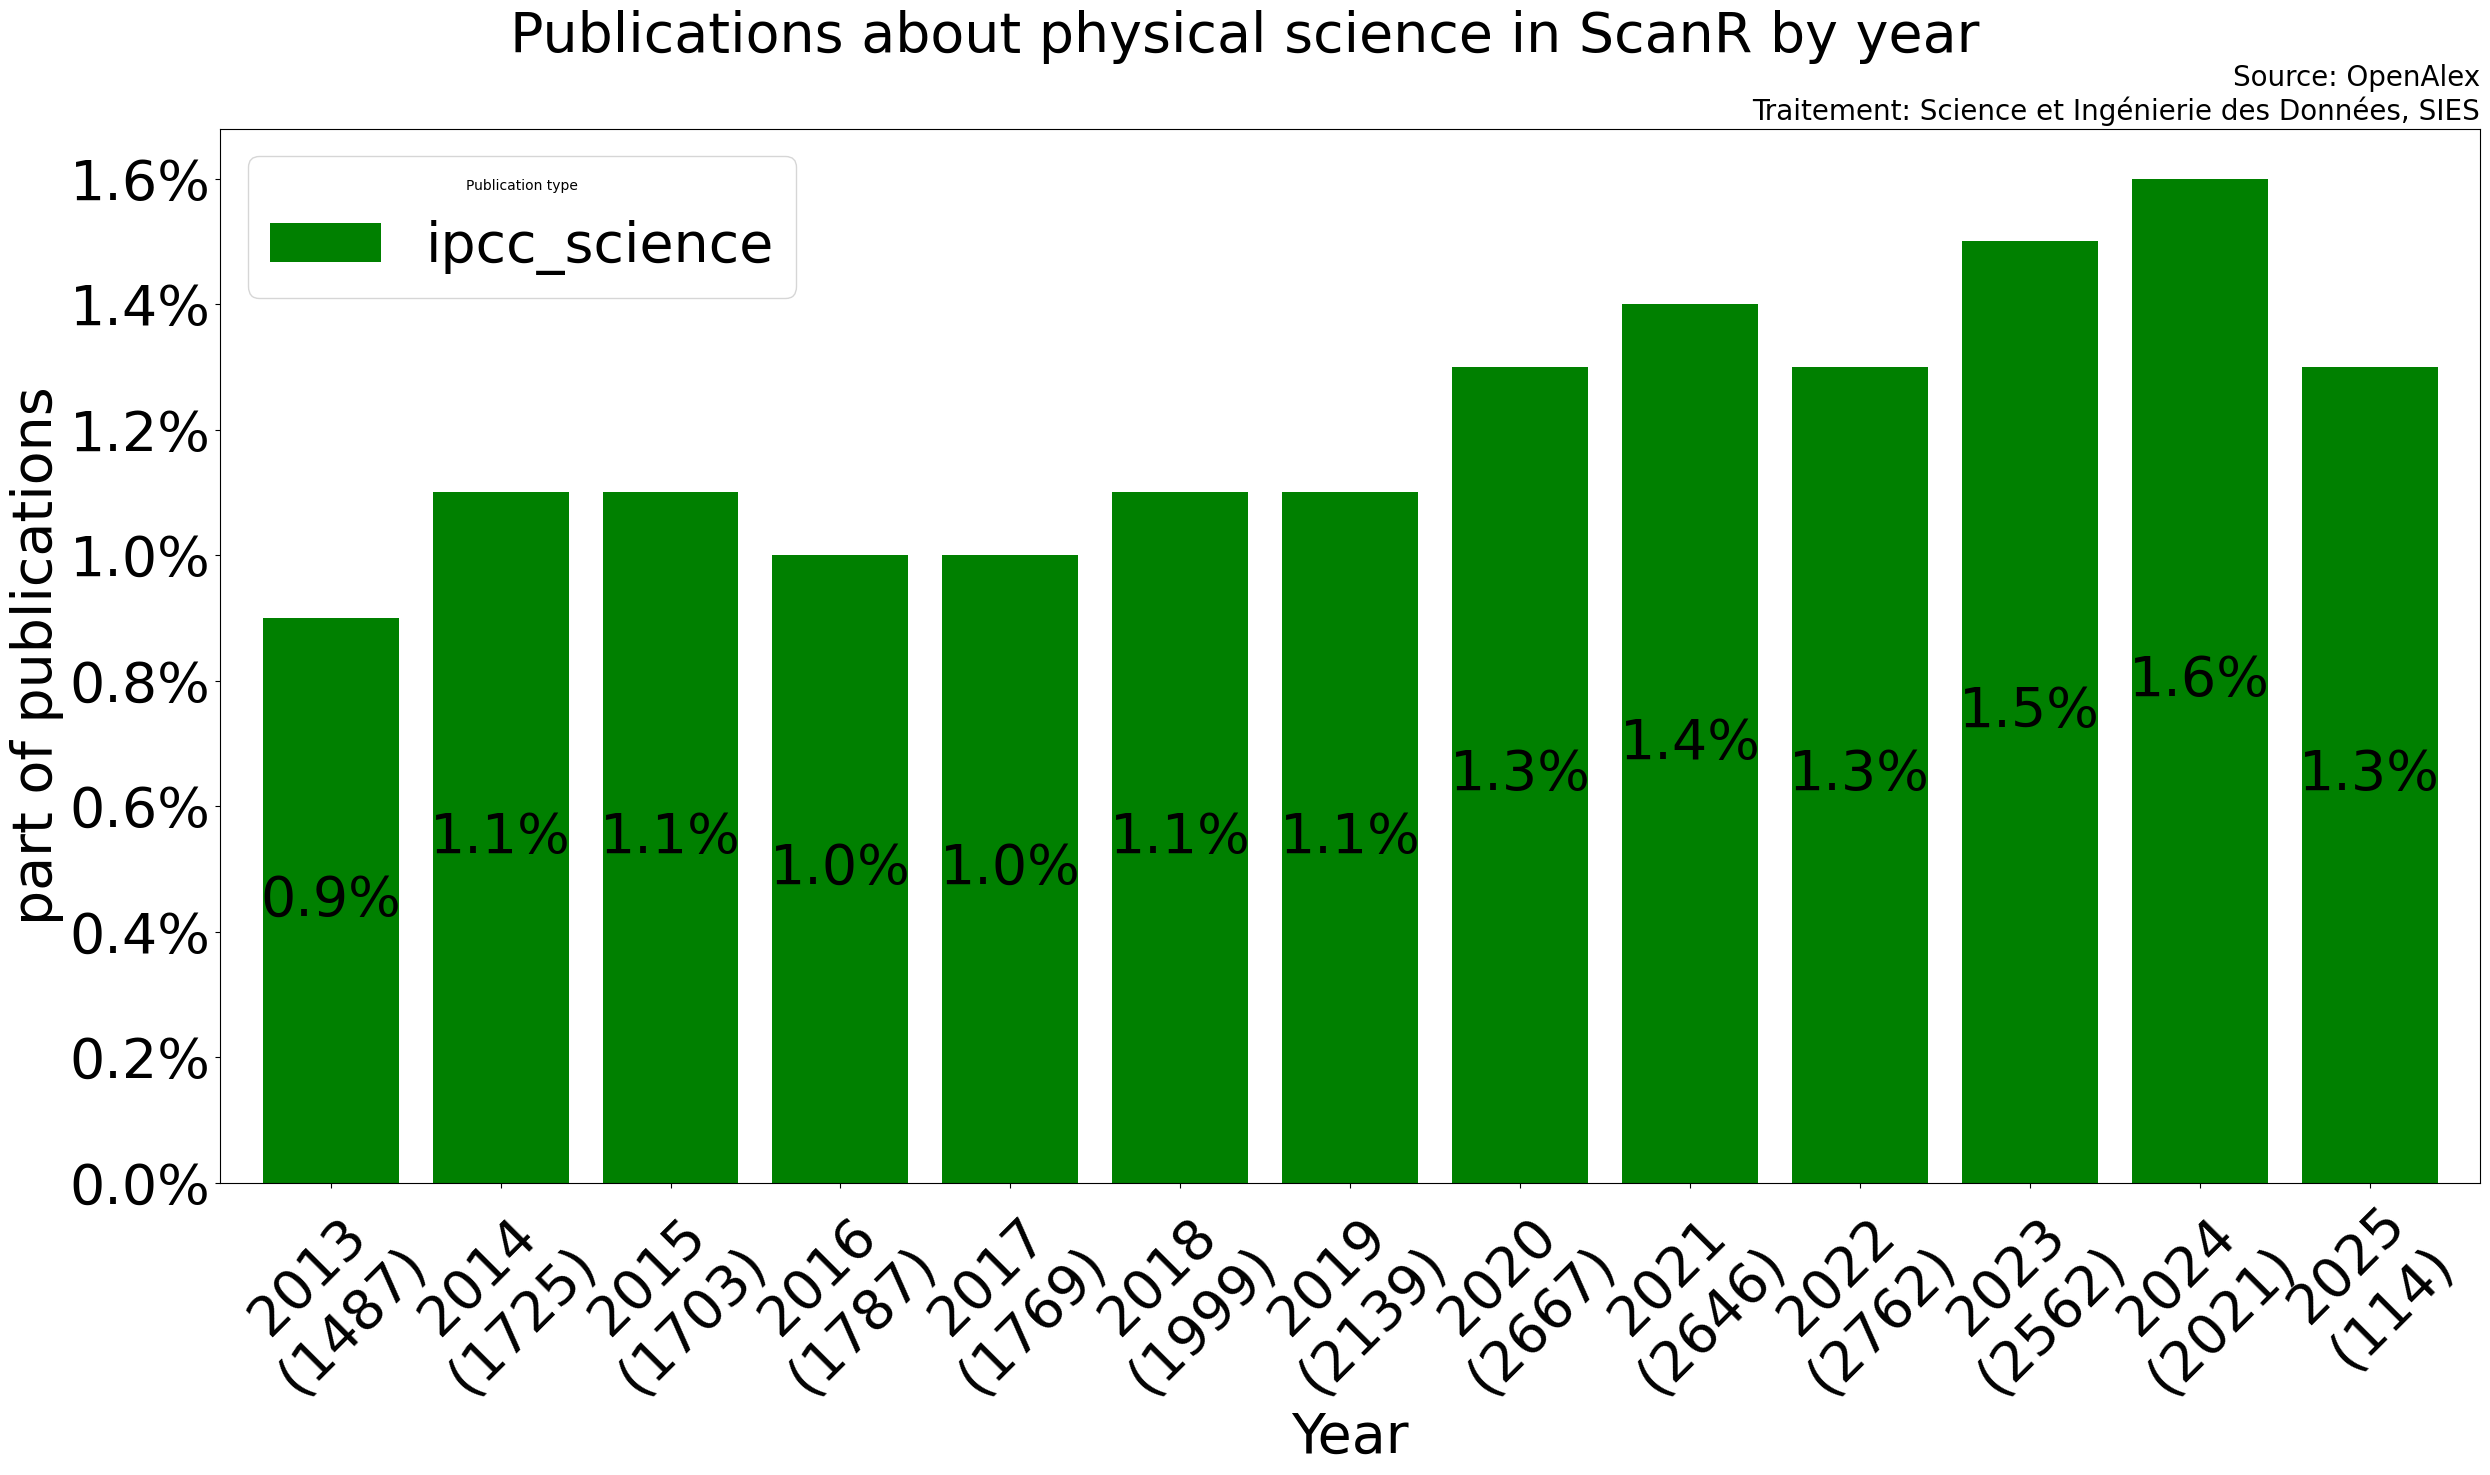

In [8]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR2')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      #data_counts[x['key']]=[]
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science','nb'])
df = df.sort_index()

ax = df['ipcc_science'].plot(kind='bar', figsize=(25, 15), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=40)

ax.set_xlabel('Year', fontsize=40)
x_labels = [f"{index}\n({int(row['nb'])})" for index, row in df.iterrows()]
ax.set_xticklabels(x_labels, rotation=45, fontsize=40)
ax.set_ylabel(f'part of publications', fontsize=40)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)

ax.legend(title='Publication type', loc='upper left', fontsize=40)

plt.suptitle("Publications about physical science in ScanR by year", size=40)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_7244\1067916454.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)


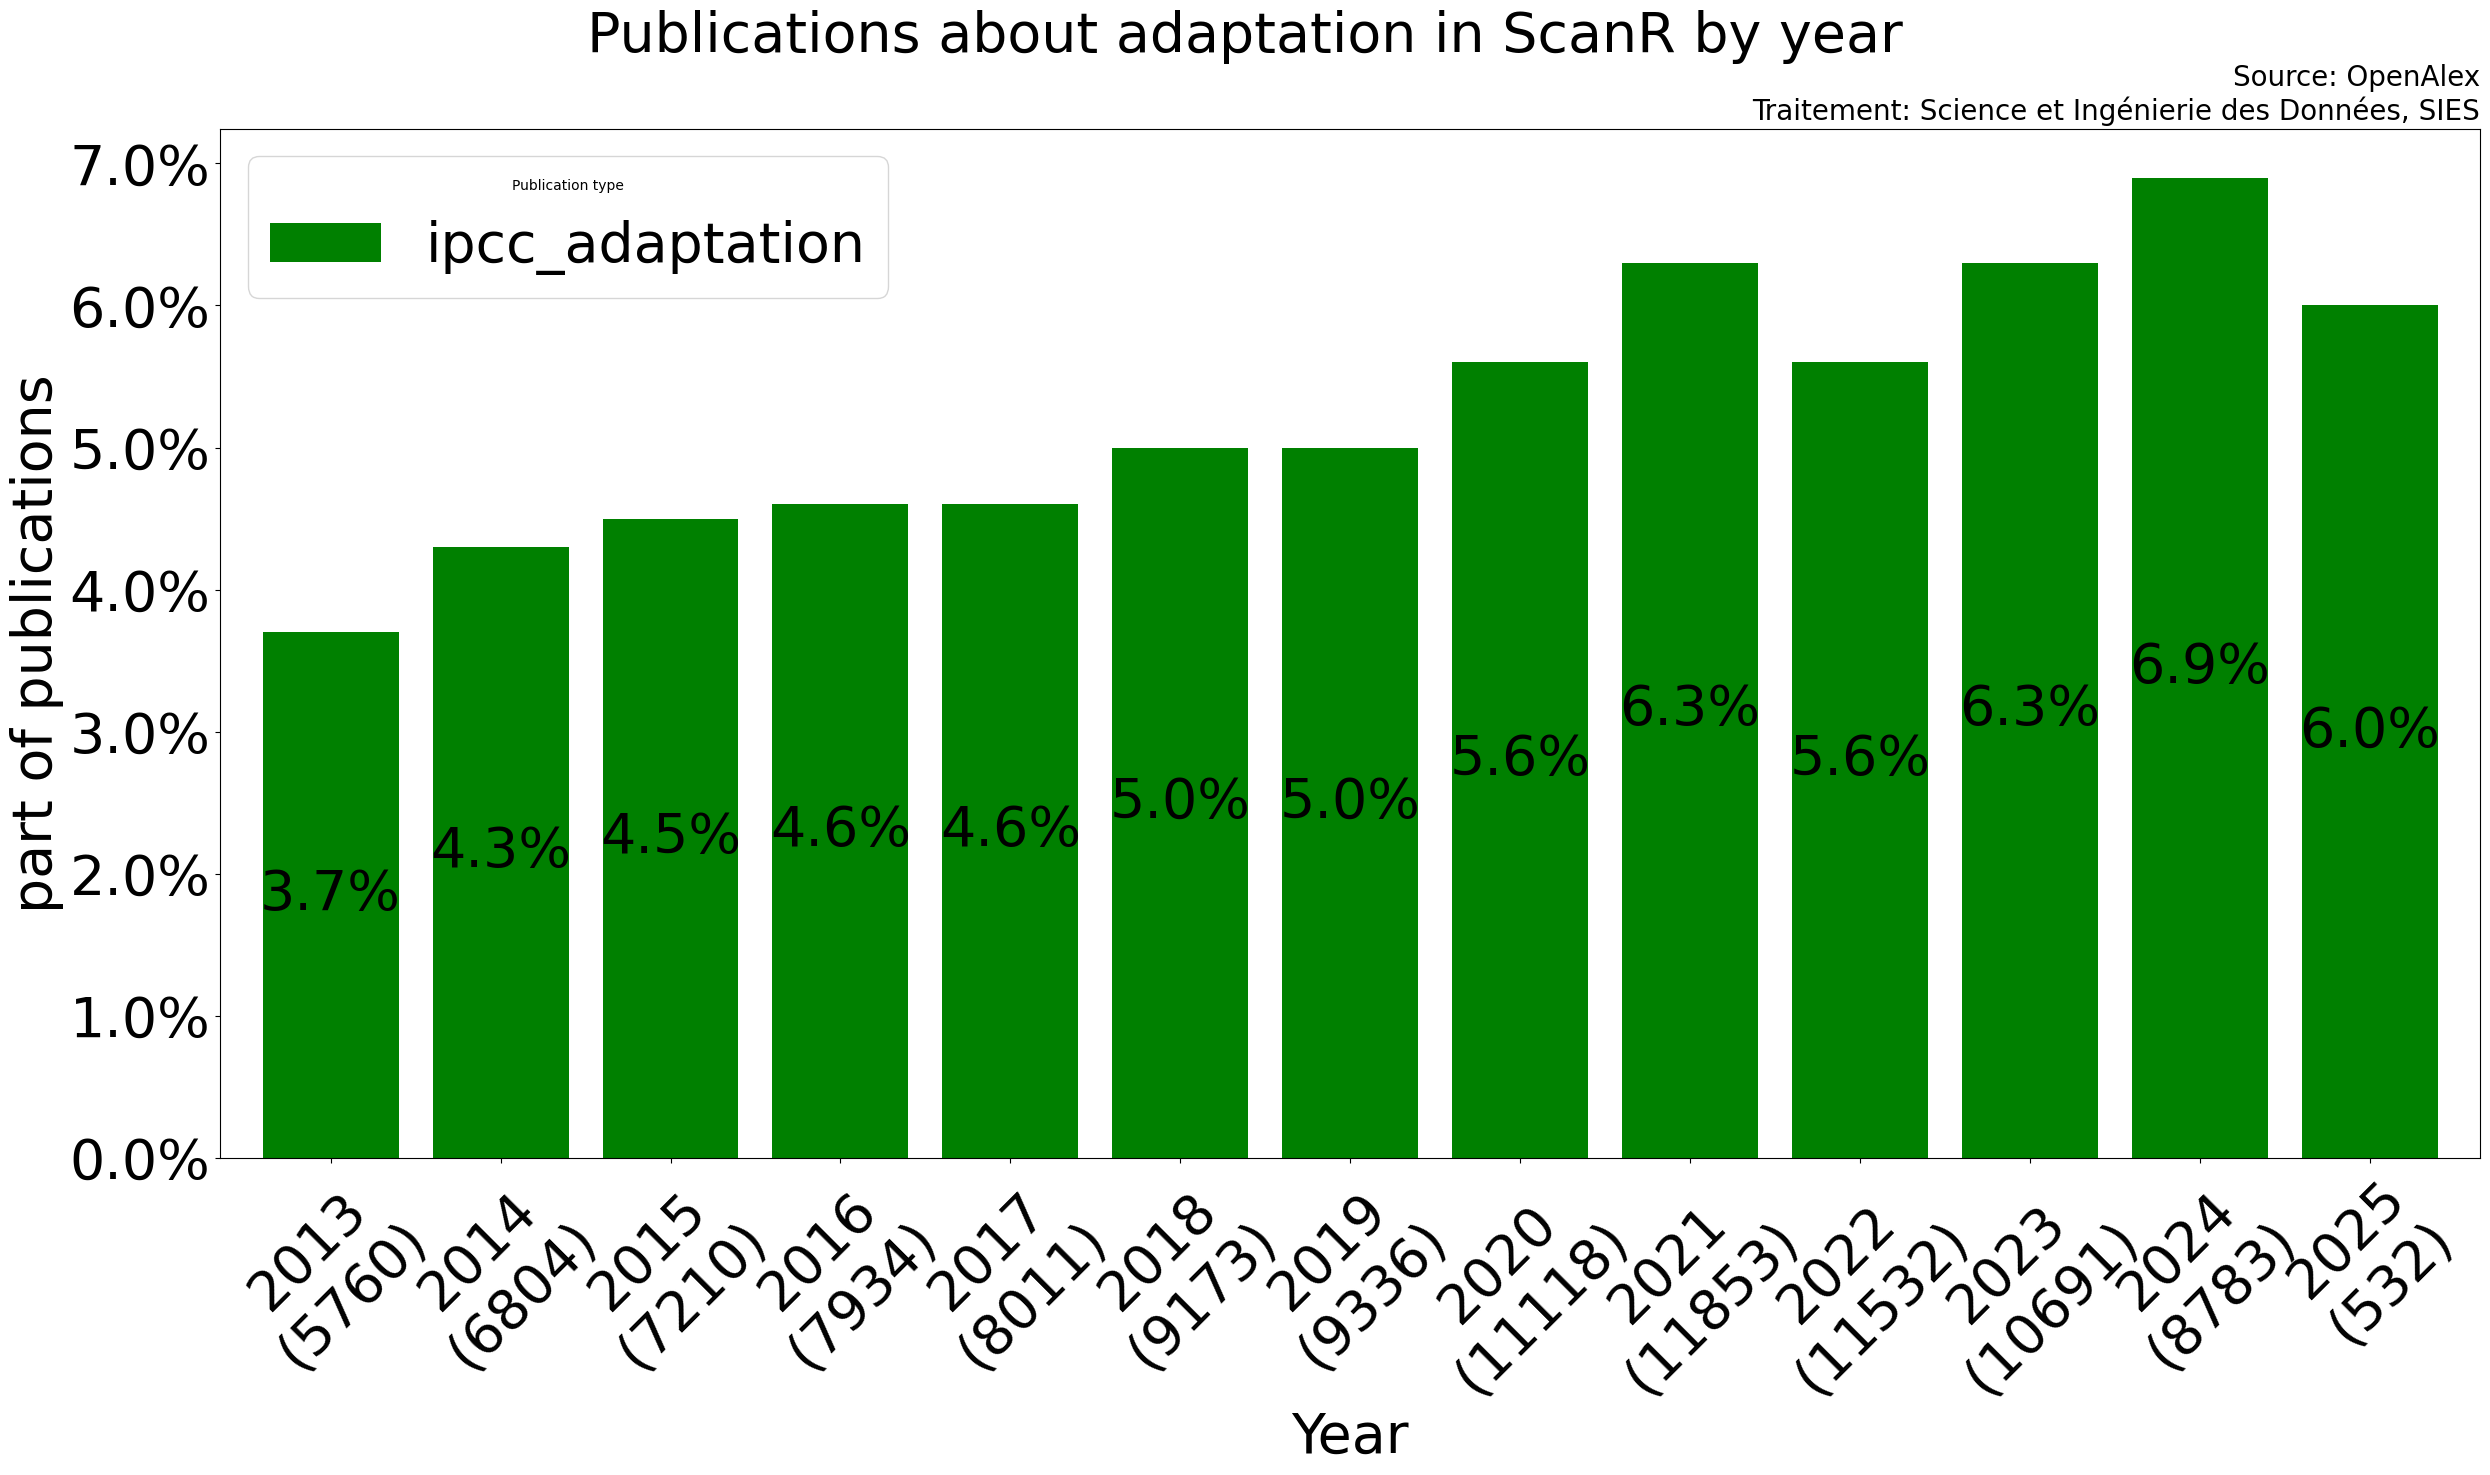

In [9]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR2')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      #data_counts[x['key']]=[]
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_adaptation','nb'])
df = df.sort_index()

ax = df['ipcc_adaptation'].plot(kind='bar', figsize=(25, 15), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=40)

ax.set_xlabel('Year', fontsize=40)
x_labels = [f"{index}\n({int(row['nb'])})" for index, row in df.iterrows()]
ax.set_xticklabels(x_labels, rotation=45, fontsize=40)
ax.set_ylabel(f'part of publications', fontsize=40)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)

ax.legend(title='Publication type', loc='upper left', fontsize=40)

plt.suptitle("Publications about adaptation in ScanR by year", size=40)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_7244\302977174.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)


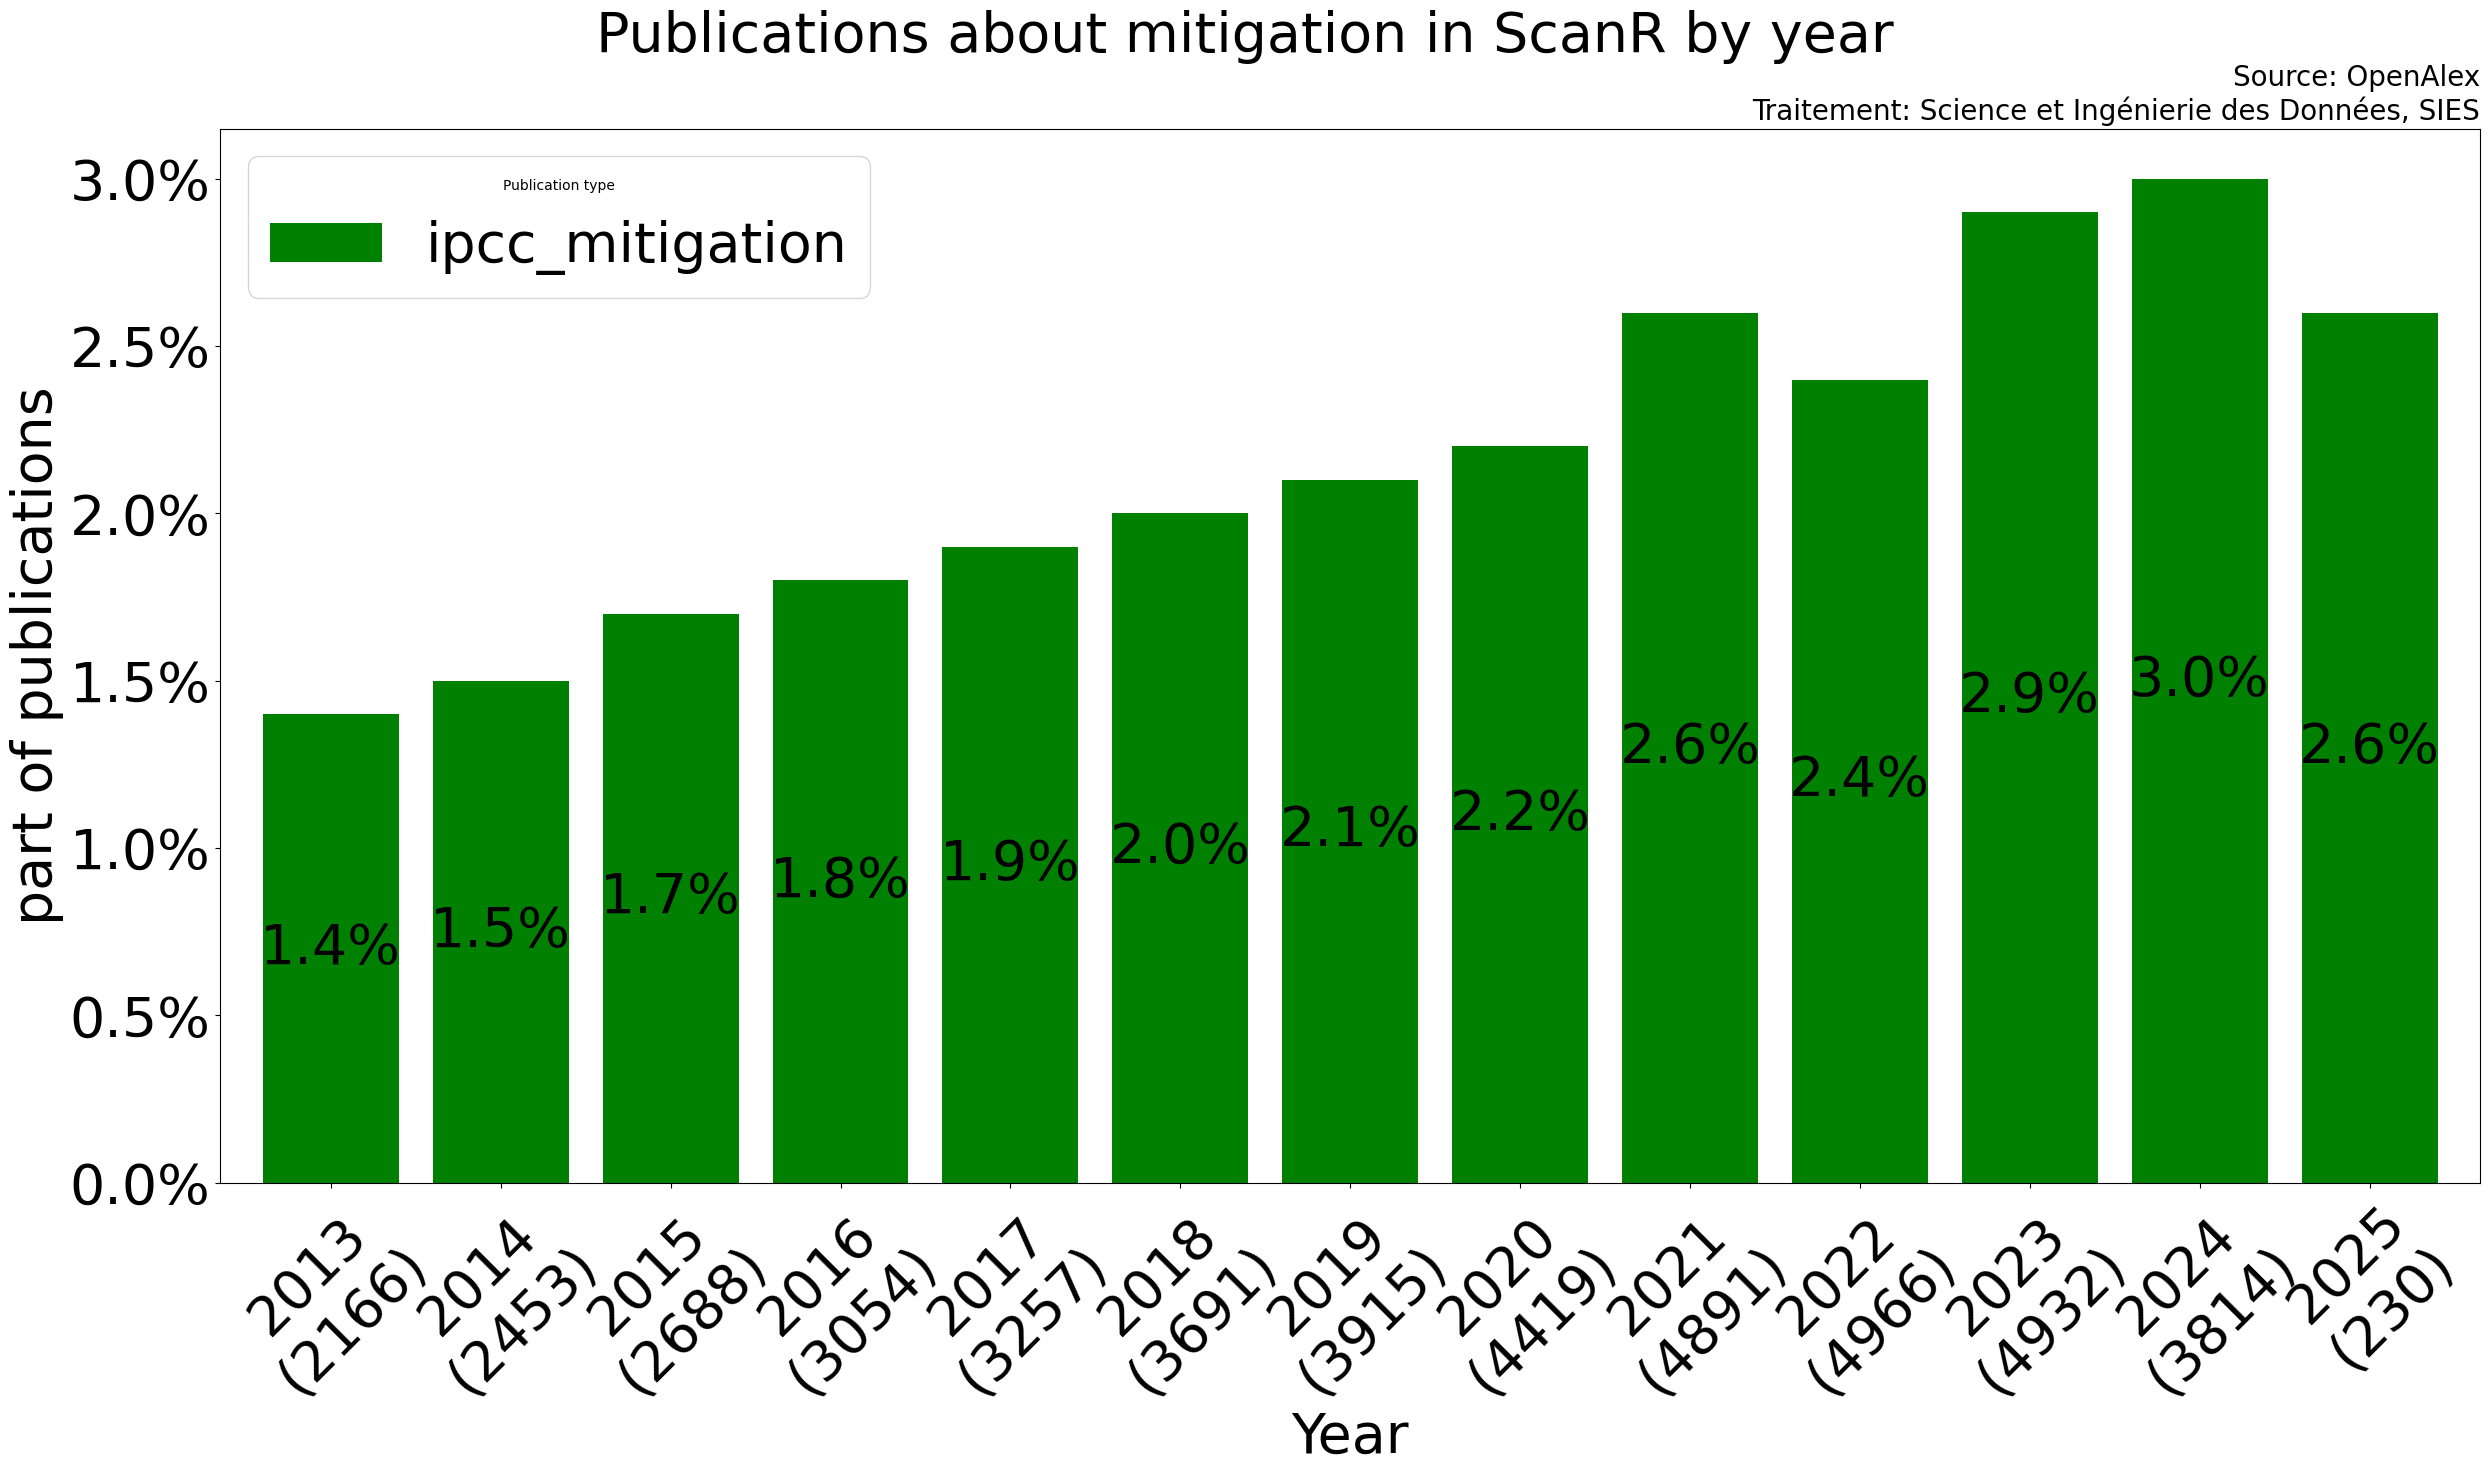

In [11]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR2')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      #data_counts[x['key']]=[]
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_mitigation','nb'])
df = df.sort_index()

ax = df['ipcc_mitigation'].plot(kind='bar', figsize=(25, 15), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc_mitigation'] / 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=40)

ax.set_xlabel('Year', fontsize=40)
x_labels = [f"{index}\n({int(row['nb'])})" for index, row in df.iterrows()]
ax.set_xticklabels(x_labels, rotation=45, fontsize=40)
ax.set_ylabel(f'part of publications', fontsize=40)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)

ax.legend(title='Publication type', loc='upper left', fontsize=40)

plt.suptitle("Publications about mitigation in ScanR by year", size=40)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

In [53]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "by_countries": {
      "terms": {
        "field": "affiliations.country.keyword",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
res=get_from_es(body,'scanR')

In [59]:
countries_ordered_en = ["United States", "United Kingdom", "Germany", "France", "China"]
countries_fr = {
    "France": "France",
    "United States": "États-Unis",
    "United Kingdom": "Royaume-Uni",
    "Germany": "Allemagne",
    "China": "Chine"
}

ipcc_labels = ["ipcc_science", "ipcc_adaptation", "ipcc_mitigation"]
labels_fr = {
    "ipcc_science": "Sciences Physiques",
    "ipcc_adaptation": "Adaptation",
    "ipcc_mitigation": "Atténuations"
}

C:\Users\haallat\AppData\Local\Temp\ipykernel_18408\3813867116.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(t)}%" for t in ax.get_yticks()], fontsize=20)


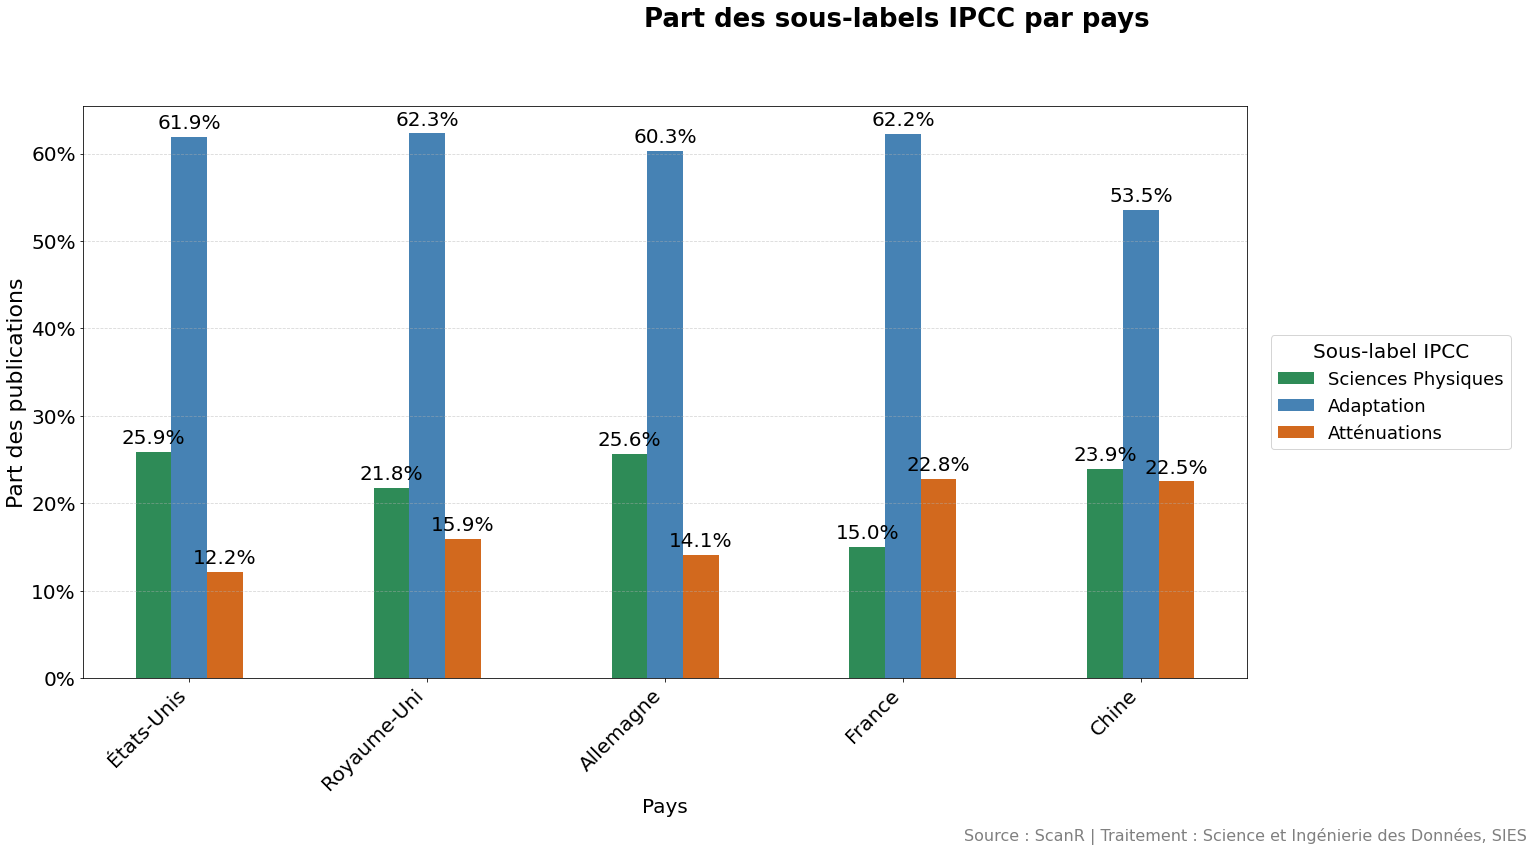

In [62]:
data = {}
for bucket in res["aggregations"]["by_countries"]["buckets"]:
    country = bucket["key"]
    if country not in countries_ordered_en:
        continue
    counts = {label: 0 for label in ipcc_labels}
    for label_bucket in bucket["predicted_labels"]["buckets"]:
        label = label_bucket["key"]
        if label in ipcc_labels:
            counts[label] = label_bucket["doc_count"]
    data[country] = counts

df = pd.DataFrame(data).T
df.index = df.index.map(countries_fr)
df = df.rename(columns=labels_fr)
ordered_countries_fr = [countries_fr[c] for c in countries_ordered_en]
df = df.loc[ordered_countries_fr]
df_prop = df.div(df.sum(axis=1), axis=0).round(3) * 100
df_plot = df_prop.T

fig, ax = plt.subplots(figsize=(25, 12))
bar_width = 0.15
colors = ['#2E8B57', '#4682B4', '#D2691E']
x_base = range(len(df_plot.columns))

for i, (label, row) in enumerate(df_plot.iterrows()):
    x = [p + i * bar_width for p in x_base]
    bars = ax.bar(x, row.values, width=bar_width, label=label, color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f"{height:.1f}%",
                ha='center',
                va='bottom',
                fontsize=20,
                color='black'
            )

ax.set_xticks([p + bar_width for p in x_base])
ax.set_xticklabels(df_plot.columns, rotation=45, ha='right', fontsize=20)
ax.set_ylabel('Part des publications', fontsize=22)
ax.set_yticklabels([f"{int(t)}%" for t in ax.get_yticks()], fontsize=20)
ax.set_xlabel('Pays', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.suptitle("Part des sous-labels IPCC par pays", fontsize=26, weight='bold')
fig.text(
    0.85, 0.01,
    "Source : ScanR | Traitement : Science et Ingénierie des Données, SIES",
    ha='right', va='bottom', fontsize=16, color='gray'
)
ax.legend(
    title="Sous-label IPCC",
    fontsize=18,
    title_fontsize=20,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.
)
plt.tight_layout(rect=[0, 0.03, 0.85, 0.92])
plt.show()


top topics ipcc

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "topics": {
          "terms": {
            "field": "primary_topic.id.keyword",  #topics.display_name.keyword
            "size": 10000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR2')

In [14]:
data

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': []}}}

In [11]:
names=[x['key'] for x in data['aggregations']['predicted_labels']['buckets'][1]['topics']['buckets']]

In [9]:
ids=[x['key'] for x in data['aggregations']['predicted_labels']['buckets'][1]['topics']['buckets']]

In [12]:
df=pd.DataFrame(list(zip(ids,names)),columns=['id','name'])
df

,id,name


In [29]:
df.loc[:,'id']=df.loc[:,'id'].apply(lambda x: str(x).replace('https://openalex.org/',''))

In [30]:
dict_topics=dict(zip(list(df.id),list(df.name)))

In [36]:
list(dict_topics.keys())

['T11475',
 'T10153',
 'T13099',
 'T14186',
 'T13641',
 'T12119',
 'T13379',
 'T13033',
 'T14162',
 'T11132',
 'T13807',
 'T10325',
 'T10039',
 'T13888',
 'T13152',
 'T14149',
 'T10001',
 'T12909',
 'T10477',
 'T13396',
 'T10048',
 'T10299',
 'T13695',
 'T10110',
 'T10413',
 'T10026',
 'T12454',
 'T10472',
 'T14402',
 'T13070',
 'T10360',
 'T11020',
 'T10158',
 'T10406',
 'T12100',
 'T10804',
 'T13156',
 'T10988',
 'T10581',
 'T10095',
 'T10351',
 'T10002',
 'T12917',
 'T10192',
 'T11287',
 'T10181',
 'T14379',
 'T10521',
 'T10224',
 'T13068',
 'T10185',
 'T11157',
 'T10165',
 'T10215',
 'T10417',
 'T10015',
 'T13534',
 'T10077',
 'T14199',
 'T10522',
 'T11482',
 'T10251',
 'T11949',
 'T10527',
 'T13372',
 'T10285',
 'T10017',
 'T11930',
 'T10207',
 'T11323',
 'T10322',
 'T10818',
 'T10580',
 'T10378',
 'T10172',
 'T10037',
 'T10231',
 'T10269',
 'T10876',
 'T11177',
 'T10142',
 'T10382',
 'T10645',
 'T10041',
 'T11016',
 'T10604',
 'T10241',
 'T14021',
 'T10025',
 'T11491',
 'T10159',

In [13]:
climat_topics=['T10753', 'T11988', 'T10122', 'T10139', 'T10577', 'T11862', 'T13377', 'T10898', 'T12981', 'T10174', 'T11405', 'T13396', 'T12213', 'T12639', 'T11056', 'T11880', 'T11753', 'T10439', 'T10766', 'T10438', 'T12806', 'T11244', 'T11186', 'T10029', 'T11588', 'T10075', 'T10017', 'T10644', 'T10895', 'T10266', 'T10230', 'T11320', 'T10341', 'T10005', 'T10347', 'T10765', 'T10032', 'T11333', 'T10226', 'T10466', 'T10647', 'T11483', 'T10330', 'T10471', 'T10199', 'T10555', 'T11259', 'T11594', 'T10643', 'T10319', 'T10487', 'T10435', 'T10659', 'T10089']

In [34]:
dict_topics['T11056']

'Physiological and biochemical adaptations'

In [11]:
df.loc[20:40,:]

,id,name
20,T10048,Particle physics theoretical and experimental ...
21,T10299,Photonic and Optical Devices
22,T13695,"Aging, Elder Care, and Social Issues"
23,T10110,earthquake and tectonic studies
24,T10413,High-pressure geophysics and materials
25,T10026,"Galaxies: Formation, Evolution, Phenomena"
26,T12454,European Political History Analysis
27,T10472,Semiconductor materials and devices
28,T14402,Political and Social Issues
29,T13070,Cultural Identity and Heritage


In [33]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
        "term": {
          "externalIds.type.keyword": "doi"
        }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013 and x['key']<=2024:
      #data_counts[x['key']]=[]
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}

In [34]:
data_counts

{2022: [9.4, 20423],
 2020: [9.3, 19472],
 2021: [10.3, 20566],
 2019: [8.3, 16482],
 2018: [8.2, 15714],
 2017: [7.7, 13949],
 2016: [7.5, 13615],
 2023: [10.7, 19172],
 2015: [7.3, 12279],
 2014: [7.0, 11660],
 2013: [6.1, 10158],
 2024: [11.7, 15545]}